# Preprocess OMIP2 Model Output

## Import packages

In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import numpy as np
import xarray as xr
import s3fs
import zarr
import util
import warnings
warnings.filterwarnings('ignore')

## Create a new Dask cluster with the Dask Gateway

In [2]:
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
##A line of trick to clean your dask cluster before you start your computation
from dask.distributed import Client
clusters=gateway.list_clusters()
print(clusters )
for cluster in clusters :
    cluster= gateway.connect(cluster.name)
    print(cluster)
    client = Client(cluster)
    client.close()
    cluster.shutdown()

[ClusterReport<name=daskhub.63604d349a674b779db6ca4c365da5de, status=RUNNING>]
GatewayCluster<daskhub.63604d349a674b779db6ca4c365da5de, status=running>


In [4]:
cluster = gateway.new_cluster(worker_memory=2, worker_cores=1)

cluster.scale(8)
cluster

## Get a client from the Dask Gateway Cluster

As stated above, creating a Dask `Client` is mandatory in order to perform following Daks computations on your Dask Cluster.

In [5]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.f739f23571714015b3ed98c5e83a5187/status,


## Open dictionary of OMIP2 simulations
With file lists taken from the ESGF Search Catalog with the following search requirements:
1. On the native grid
2. Have the varaibles:`umo`, `vmo`, `so`, `thetao`, `zos`, `mlotst`, `siconc`, `deptho`, `areacello`
3. At monthly time steps
4. The last 61 years of the simulation

In [6]:
# Load in file of model names and fnames
model_fnames_dict = np.load("models.npy", allow_pickle=True).item()

In [7]:
list(model_fnames_dict.keys())

['TaiESM1-TIMCOM2',
 'NorESM2-LM',
 'MRI-ESM2-0',
 'TaiESM1-TIMCOM',
 'CMCC-CM2-SR5',
 'FGOALS-f3-L',
 'ACCESS-OM2',
 'ACCESS-OM2-025',
 'MIROC6',
 'CNRM-CM6-1',
 'EC-Earth3',
 'CMCC-CM2-HR4',
 'CNRM-CM6-1-HR']

## Function for writing zarr file to bucket

In [8]:
def write_dataset_to_zarr(ds,sim_name):
    # set path on bucket
    path='WAFFLES/OMIP2/'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs = {'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # make file name for variable in simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    
    # write variable to zarr
    %time ds.to_zarr(store=store,mode='w',consolidated=True)
    
    return

## Preprocess and write subsets of all model data
Open a model and save each variable in the dataset as a `zarr` file in the `waffles` bucket

## Testing below this line

In [9]:
sim_name = list(model_fnames_dict.keys())[0]

In [10]:
sim_name

'TaiESM1-TIMCOM2'

In [11]:
%%time
# load model from sim_name
ds = util.load_ds_from_esgf_file_in_model_fnames_dict(sim_name,model_fnames_dict)
# ds = util.load_ds_from_esgf_file_in_model_fnames_dict(sim_name, model_fnames_dict,flg_onefile=True)

CPU times: user 2.69 s, sys: 287 ms, total: 2.98 s
Wall time: 2min 31s


In [12]:
ds

<xarray.Dataset>
Dimensions:        (y: 46, x: 320, time: 732, lev: 55, vertex: 4, bnds: 2)
Coordinates:
  * y              (y) int32 242 243 244 245 246 247 ... 282 283 284 285 286 287
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(46, 50, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(46, 50, 4), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 46, 50), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 46, 50), meta=np.ndarray>
  * time           (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
  * lev            (lev) float64 5.501 16.7 28.18 ... 5.061e+03 5.542e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(55, 2), meta=np.ndarray>
Dimensions without coordinates: vertex, bnds
Data variables:
    areacello      (y, x) float32 dask.array<chunksize=(46, 50), meta=np.ndarray>
    deptho         (y, x) float32 dask.array<chunksize=(46, 50), meta=np.ndarray>
    mlotst         (time, y, x) float32 dask.array<chunksize=(732, 46, 50), meta=np.ndarray>
    so             (time, lev, y, x) float32 dask.array<chunksize=(732, 55, 46, 50), meta=np.ndarray>
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(732, 55, 46, 50), meta=np.ndarray>
    umo            (time, lev, y, x) float32 dask.array<chunksize=(732, 55, 46, 50), meta=np.ndarray>
    vmo            (time, lev, y, x) float32 dask.array<chunksize=(732, 55, 46, 50), meta=np.ndarray>
    zos            (time, y, x) float32 dask.array<chunksize=(732, 46, 50), meta=np.ndarray>
Attributes: (12/43)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    branch_method:         no parent
    contact:               Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    creation_date:         2021-12-09T07:29:11Z
    data_specs_version:    01.00.33
    ...                    ...
    tracking_id:           hdl:21.14100/a902e579-18e1-4706-8794-4409f62ef8e2
    variable_id:           areacello
    variant_label:         r1i1p1f1
    license:               CMIP6 model data produced by REQUIRED is licensed ...
    cmor_version:          3.5.0
    EXTRA_DIMENSION.bnds:  2

In [13]:
list(ds.keys())

['areacello', 'deptho', 'mlotst', 'so', 'thetao', 'umo', 'vmo', 'zos']

In [29]:
ds_sub = ds[['areacello','deptho','mlotst']]

In [30]:
ds_sub

<xarray.Dataset>
Dimensions:    (y: 46, x: 320, time: 732)
Coordinates:
  * y          (y) int32 242 243 244 245 246 247 248 ... 282 283 284 285 286 287
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    lat        (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
  * time       (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
Data variables:
    areacello  (y, x) float32 dask.array<chunksize=(46, 50), meta=np.ndarray>
    deptho     (y, x) float32 dask.array<chunksize=(46, 50), meta=np.ndarray>
    mlotst     (time, y, x) float32 dask.array<chunksize=(732, 46, 50), meta=np.ndarray>
Attributes: (12/43)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    branch_method:         no parent
    contact:               Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    creation_date:         2021-12-09T07:29:11Z
    data_specs_version:    01.00.33
    ...                    ...
    tracking_id:           hdl:21.14100/a902e579-18e1-4706-8794-4409f62ef8e2
    variable_id:           areacello
    variant_label:         r1i1p1f1
    license:               CMIP6 model data produced by REQUIRED is licensed ...
    cmor_version:          3.5.0
    EXTRA_DIMENSION.bnds:  2

In [35]:
write_dataset_to_zarr(ds,sim_name)

s3://WAFFLES/OMIP2/


RuntimeError: NetCDF: Authorization failure

In [32]:
def read_dataset_from_zarr(sim_name):
    # set path on bucket
    path='WAFFLES/OMIP2/'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # file name for simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    
    # read variable from zarr
    ds=xr.open_zarr(store=store)
    
    return ds

In [33]:
test = read_dataset_from_zarr(sim_name)

s3://WAFFLES/OMIP2/


In [34]:
test

<xarray.Dataset>
Dimensions:    (y: 46, x: 320, time: 732)
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(46, 50), meta=np.ndarray>
  * time       (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * y          (y) int32 242 243 244 245 246 247 248 ... 282 283 284 285 286 287
Data variables:
    areacello  (y, x) float32 dask.array<chunksize=(46, 50), meta=np.ndarray>
    deptho     (y, x) float32 dask.array<chunksize=(46, 50), meta=np.ndarray>
    mlotst     (time, y, x) float32 dask.array<chunksize=(732, 46, 50), meta=np.ndarray>
Attributes: (12/43)
    Conventions:           CF-1.7 CMIP-6.2
    EXTRA_DIMENSION.bnds:  2
    activity_id:           OMIP
    branch_method:         no parent
    cmor_version:          3.5.0
    contact:               Dr. Yu-Heng Tseng (tsengyh@ntu.edu.tw)
    ...                    ...
    table_id:              Ofx
    table_info:            Creation Date:(18 November 2020) MD5:21cc207291683...
    title:                 TaiESM1-TIMCOM2 output prepared for CMIP6
    tracking_id:           hdl:21.14100/a902e579-18e1-4706-8794-4409f62ef8e2
    variable_id:           areacello
    variant_label:         r1i1p1f1

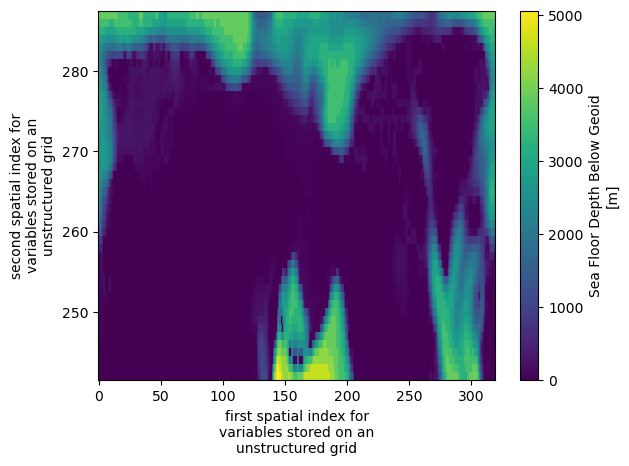

In [25]:
test.deptho.plot()

In [39]:
target = s3fs.S3FileSystem(anon=False,client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'})
path='WAFFLES/OMIP2/CMCC-CM2-SR5'
target.ls(path)

[]

## Some useful, spare code